 <h1><center> <font color='green'>CNN  Basado en TL Inception V3 </font></center></h1> 

 <h1><center> <font color='blue'>Librerías</font></center></h1> 


In [1]:
"""Importar librerias para realizar CNN"""
import os
"""Cargar las imagenes"""
import cv2
from PIL import Image
"""Tensoflow para las redes neuronales"""
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
"""Librería para calculo numerico"""
import numpy as np
"""Libreria para graficas"""
import matplotlib.pyplot as plt
"""Importa para dividir el conjunto de datos en entrenamiento y prueba"""
from sklearn.model_selection import train_test_split
"""Librería que que ofrece metricas"""
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
"""Importa datos de señales de registro de archivos de ejecuciones
de simulación disponibles para la aplicación en tiempo real seleccionadas"""
import time
import math
import logging

<h1><center> <font color='orange'>Carga y exploración de datos</font></center></h1> 

In [2]:
"""Definición del tamaño, array de las imagenes"""
IMG_SHAPE  = 227
batch_size = 32
random_seed = 9

In [3]:
fpath = "./vocales"
categories = os.listdir(fpath)
print("Lista de categorias = ",categories,"\n\nNo. de categorias = ", len(categories))

Lista de categorias =  ['a', 'e', 'i', 'o', 'u'] 

No. de categorias =  5


In [4]:
"""Funcion para cargar las imagenes por categorias"""
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')

            img_lst.append(np.array(img_array))

            labels.append(index)
    return img_lst, labels
"""Cargar las imagenes desde las categorias"""
images, labels = load_images_and_labels(categories)
"""Mostrar la cantidad de imagenes cargadas"""
print("Nº de imágenes cargadas = ",len(images),"\nNo. de etiquetas cargadas = ",len(labels))
print(type(images),type(labels))

Nº de imágenes cargadas =  1000 
No. de etiquetas cargadas =  1000
<class 'list'> <class 'list'>


In [5]:
"""Variables para ver el array de las imagenes y los label"""
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1000, 227, 227, 3) 
Labels shape =  (1000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


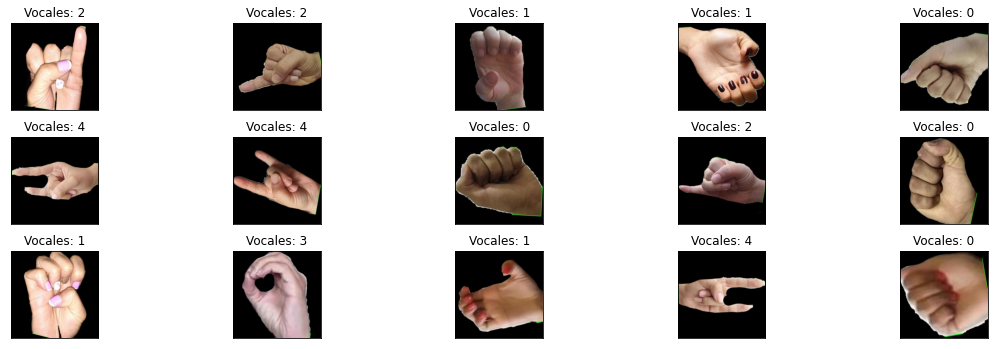

In [6]:
"""Función para visualizar imagenes aleatorias """
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(15):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(5 , 5 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        """Array de las vocales"""
        plt.title('Vocales: {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
"""Mostrar imagenes con sus labels"""
display_rand_images(images, labels)

<h1>Definición del conjunto de datos para pruebas y entrenamiento

In [7]:
"""Primero se reorganizan los datos"""

"""Obtener números igualmente espaciados en un rango dado"""
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

"""Mezclar todos los valores igualmente espaciados en la lista 'n'"""
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238

In [8]:
"""El segundo paso es la mezcla de datos"""

"""imágenes aleatorias y datos de etiquetas correspondientes en ambas listas"""
images = images[n]
labels = labels[n]

print("Forma de las imágenes después de la mezcla = ",images.shape,"\nForma de las etiquetas después de mezclar= ",labels.shape)

Forma de las imágenes después de la mezcla =  (1000, 227, 227, 3) 
Forma de las etiquetas después de mezclar=  (1000,)


### Normalización

In [9]:
"""Normalizacion de los datos, segun su tipo: float, int"""
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Forma de las imágenes después de la normalización = ",images.shape)

Forma de las imágenes después de la normalización =  (1000, 227, 227, 3)


### Training and Testing

In [10]:
'''Se divide el conjunto de datos en 80% para entrenamiento y 20% para prueba'''
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]

"""Mostrar los array en cada parte del entrenamiento y la prueba"""

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (742, 227, 227, 3)
y_train shape =  (742,)

x_test shape =  (200, 227, 227, 3)
y_test shape =  (200,)

x_val shape =  (58, 227, 227, 3)
y_val shape =  (58,)


In [11]:
"""Estructura One-hot-encode"""
y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)
y_val = to_categorical(y_val, 5)


 <h1><center> <font color='purple'>Implementación del modelo CNN Basado en TL Inception V3</font></center></h1> 

In [12]:
"""Función para el pre-entrenamiento del modelo, con InceptionV3"""
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=x_train[0].shape, include_top=False, weights="imagenet")


87924736/87910968 [==============================] - 5s 0us/step


In [13]:
"""Pre-entrenar el modelo por capas"""
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

In [14]:
last_layer = pre_trained_model.get_layer('mixed10')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)
model = tf.keras.Model(pre_trained_model.input, x)

## Entrenamiento del Modelo

In [15]:
"""Configuracion para compilar el modelo, tambien se optimiza"""
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [16]:
"""Resumen del Modelo"""
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 113, 113, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 113, 113, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 113, 113, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
steps_per_epoch = (x_train.shape[0]//batch_size)
validation_steps = (x_val.shape[0] // batch_size)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [18]:
"""Visualizar el array de los datos de entrenamiento"""
x_train.shape,y_train.shape

((742, 227, 227, 3), (742, 5))

In [19]:
start_time = time.time()

history = model.fit(x_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 50,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = batch_size,
    callbacks=[es],
    verbose=1)

logging.basicConfig(filename=r"C:/Users/gulna/ProyectoMinería/CNN_TL_InceptionV3_logs/CNN_TL_InceptionV3_logs.txt", level=logging.INFO)
logging.info("Training Execution Time:" + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

Epoch 1/50
23/23 [==============================] - 42s 1s/step - loss: 4.4215 - acc: 0.4103 - val_loss: 0.6038 - val_acc: 0.7500
Epoch 2/50
23/23 [==============================] - 27s 1s/step - loss: 0.7509 - acc: 0.7324 - val_loss: 0.4134 - val_acc: 0.8125
Epoch 3/50
23/23 [==============================] - 27s 1s/step - loss: 0.4291 - acc: 0.8423 - val_loss: 0.3998 - val_acc: 0.8125
Epoch 4/50
23/23 [==============================] - 28s 1s/step - loss: 0.3429 - acc: 0.8704 - val_loss: 0.3559 - val_acc: 0.8125
Epoch 5/50
23/23 [==============================] - 26s 1s/step - loss: 0.2937 - acc: 0.8944 - val_loss: 0.3929 - val_acc: 0.8750
Epoch 6/50
23/23 [==============================] - 25s 1s/step - loss: 0.2238 - acc: 0.9268 - val_loss: 0.2414 - val_acc: 0.9062
Epoch 7/50
23/23 [==============================] - 24s 1s/step - loss: 0.1992 - acc: 0.9352 - val_loss: 0.2612 - val_acc: 0.9062
Epoch 8/50
23/23 [==============================] - 24s 1s/step - loss: 0.1945 - acc: 0.91

In [20]:
"""Crear un archivo de tipo json"""
model_json = model.to_json()
with open("CNN_TL_InceptionV3_Vocales_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save("CNN_TL_InceptionV3_Vocales_Classifier.h5")
"""Guardar en el disco duro"""
print("Saved model to disk")
model.save_weights("CNN_TL_InceptionV3_Vocales.h5")

Saved model to disk


## Evaluación del modelo

In [21]:
"""Función de inicio del tiempo"""
start_time = time.time()

loss, accuracy = model.evaluate(x_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

logging.info("Tiempo de ejecución de la evaluación: " + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
logging.info("test_loss:" + str(loss))
logging.info("test accuracy:" + str(accuracy))

7/7 [==============================] - 6s 849ms/step - loss: 0.1610 - acc: 0.9500
test_loss: 16.10
test_accuracy: 95.00


## Métricas de Evaluación

In [22]:
"""Función para las pruebas del modelo"""
model_probs = model.predict(x_test,batch_size=batch_size,verbose=0)
"""predecir clases nítidas para el conjunto de prueba"""
model_classes = np.argmax(model_probs,axis=1)
"""reducir a matriz 1d"""
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
"""Accuracy: (tp + tn) / (p + n)"""
accuracy = accuracy_score(y_test_reduced, model_classes)*100
"""Precision tp / (tp + fp)"""
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
"""Recall: tp / (tp + fn)"""
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
"""F1: 2 tp / (2 tp + fp + fn)"""
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)

Accuracy: 95.00
F1 score: 95.04
Precision: 95.35
Recall: 95.00


## Gráfica History

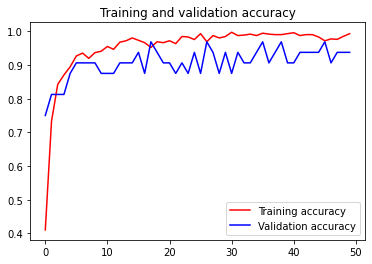

In [23]:
"""Funciones para graficar los history de validacion y el accuracy"""
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - CNN-based TL.png")
plt.show()

In [24]:
"""Predicción del Modelo"""
y_pred = model.predict(x_test)

In [25]:
"""Mostrar el array del y_pred"""
y_pred.round()

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0.

In [26]:
"""Visualizar las métricas del modelo"""
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_pred.round(), y_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        39
           1       0.88      1.00      0.93        35
           2       0.96      0.86      0.91        50
           3       1.00      1.00      1.00        46
           4       0.93      0.93      0.93        30

   micro avg       0.95      0.95      0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200
 samples avg       0.95      0.95      0.95       200



In [27]:
"""Visualización del Accuracy"""
accuracy = model.evaluate(x_test,y_test,batch_size=32)
print("Accuracy: ",accuracy[1]*100)

7/7 [==============================] - 6s 816ms/step - loss: 0.1610 - acc: 0.9500
Accuracy:  94.9999988079071


In [28]:
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

In [29]:
"""Reporte de clasificación de las métricas"""
report = classification_report(Y_true, Y_pred_classes, target_names=categories)
print(report)

              precision    recall  f1-score   support

           a       0.97      0.97      0.97        39
           e       1.00      0.88      0.93        40
           i       0.86      0.96      0.91        45
           o       1.00      1.00      1.00        46
           u       0.93      0.93      0.93        30

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



 <h1><center> <font color='red'>Matriz de Confusión</font></center></h1> 

In [30]:
"""Estructurar la matriz de confusion"""
confusion = confusion_matrix(Y_true,Y_pred_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[38  0  1  0  0]
 [ 1 35  4  0  0]
 [ 0  0 43  0  2]
 [ 0  0  0 46  0]
 [ 0  0  2  0 28]]


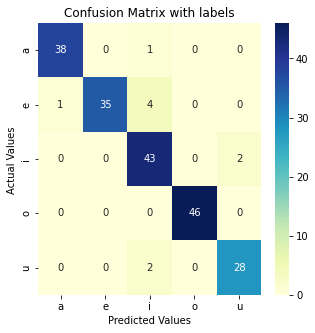

In [31]:
"""Librería para graficar la matriz de confusion"""
import seaborn as sns
plt.figure(figsize=(5, 5))

ma = sns.heatmap(confusion, cmap="YlGnBu", annot=True)
ma.set_title('Confusion Matrix with labels')
ma.set_xlabel('Predicted Values')
ma.set_ylabel('Actual Values ')
ma.xaxis.set_ticklabels(categories)
ma.yaxis.set_ticklabels(categories)

plt.show()